In [1]:
##Define the dataset here


import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision


class CarDataset(Dataset):
    def __init__(self, guide_file, transform):
        with open(guide_file, 'r') as f_r:
            self.lines = f_r.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.lines)
    def __getitem__(self, index):
        filename, make, model = self.lines[index].strip().split(' ')
        model = int(model)
        make = int(make)
        filename = '../Dataset' + filename[1:]
        image = Image.open(filename)
        if self.transform :
            image = self.transform(image)
        return {'image':image,'make': make, 'model':model}

    
    
## As suggested by Yongwei Hou, the image size are all conmfined to H=224, W=224
    
transform = transforms.Compose([
    transforms.Resize(( 224,224)),
    transforms.ToTensor()
]
)          

##The full_model_name_updated.txt ignores those images in CMYK format, there is actually only one such image in the 
##whole dataset (/data/image/116/1151/2014/bdb3633701473c.jpg) 

dataset= CarDataset('../Dataset/full_make_model_name.txt', transform)

In [2]:
#Split the dataset into trainig set and test(validation) set
import random
test_indices = random.sample(range(0, len(dataset)), 2000)
train_indices = [x for x in list(range(0, len(dataset))) if x not in test_indices]
train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

##Using the dataset to construct the dataloader here. drop_last=True (in case the last batch doesn't have enought
##data), shuffl=True(otehrwise the same model images always gather together, which is bad for training) 
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True, drop_last = True, num_workers= 4) 
test_loader = DataLoader(test_set, batch_size=64, shuffle = True, drop_last = True, num_workers=4)

In [3]:
import torchvision

##Use the pre-implemented model in torchvision model zoo
# model_model = torchvision.models.resnet50(pretrained=False, progress=True)
# model_make = torchvision.models.resnet34(pretrained=False, progress=True)
##tune the last layer to 2004 output, in accordance we have 2004 car models in this dataset
# model_model.fc = torch.nn.Linear(in_features = 2048, out_features = 2004)
# model_make.fc = torch.nn.Linear(in_features = 512, out_features = 163)
# Detect if GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_model = model_model.to(device)
# model_make = model_make.to(device)





class CarMakeModelClassifier(torch.nn.Module):
    def __init__(self, device):
        super(CarMakeModelClassifier, self).__init__()
        self.device = device
        self.make_classifier = torchvision.models.resnet34(pretrained=False, progress=True)
        self.make_classifier.fc = torch.nn.Linear(in_features = 512, out_features = 163)
        self.model_classifier = torchvision.models.resnet50(pretrained=False, progress=True)
        self.model_classifier.fc = torch.nn.Linear(in_features = 2048, out_features = 2004)
        self.make_classifier = self.make_classifier.to(device)
        self.model_classifier = self.model_classifier.to(device)
    def forward(self, x):
        make = self.make_classifier(x.to(self.device))
        model = self.model_classifier(x.to(self.device))
        return {'make':make, 'model':model}

classifier = CarMakeModelClassifier(device)

In [4]:
#Use Adam as optimizer, maybe this is not the best choice
optimizer_model = torch.optim.Adam(classifier.model_classifier.parameters())
optimizer_make = torch.optim.Adam(classifier.make_classifier.parameters())
#Use crossentropy loss for classification task
criterion = torch.nn.CrossEntropyLoss()

In [5]:

epoch_num = 10
for epoch in range(epoch_num):
    classifier.train() #set model in training mode
    for index, batch in enumerate(train_loader):
        images = batch['image']
        makes = batch['make'].to(device)
        models = batch['model'].to(device)
        output = classifier(images)
        
        optimizer_model.zero_grad()
        optimizer_make.zero_grad()
        loss1 = criterion(output['make'], makes)
        loss1.backward()
        loss2 = criterion(output['model'], models)
        loss2.backward()
        optimizer_model.step()
        optimizer_make.step()
        print("\r"+'Epoch: ' + str(epoch) +' Index: '+ str(index) + ' Train Loss: ' + str(loss1.item())+'\t'+str(loss2.item()), end = '')
        
    loss1_record = []
    loss2_record = []
    with torch.no_grad(): #No need to keep back propograrion graph in evaluation phase, save some space
        classifier.eval()#set model in evaluation mode, especially for batch normalization layer
        for batch in test_loader:
            images = batch['image']
            makes = batch['make'].to(device)
            models = batch['model'].to(device)
            output = classifier(images)
            loss1 = criterion(output['make'], makes)
            loss2 = criterion(output['model'], models)
            loss1_record.append(loss1.item())
            loss2_record.append(loss2.item())
    loss1 = sum(loss1_record)/len(loss1_record)
    loss2 = sum(loss2_record)/len(loss2_record)
    print('\n epoch: '+str(epoch)+', validation loss: '+str(loss1)+'\t'+str(loss2))

Epoch: 0 Index: 2104 Train Loss: 3.915083885192871	6.57444620132446345
 epoch: 0, validation loss: 4.0043052165739	6.560347757031841
Epoch: 1 Index: 2104 Train Loss: 3.3836514949798584	5.3008232116699225
 epoch: 1, validation loss: 3.5732823725669616	6.214358422064012
Epoch: 2 Index: 2104 Train Loss: 2.543501615524292	3.73898100852966305
 epoch: 2, validation loss: 2.563773085994105	4.024179704727665
Epoch: 3 Index: 2104 Train Loss: 2.0627591609954834	2.7982041835784914
 epoch: 3, validation loss: 1.9357063847203408	3.4586043050212245
Epoch: 4 Index: 2104 Train Loss: 1.9028621912002563	1.6953413486480713
 epoch: 4, validation loss: 1.6469346246411722	2.605375543717415
Epoch: 5 Index: 2104 Train Loss: 0.8539658784866333	1.2398273944854736
 epoch: 5, validation loss: 1.3629789294735077	1.5929880334484963
Epoch: 6 Index: 2104 Train Loss: 0.7623969912528992	0.710620880126953157
 epoch: 6, validation loss: 1.27189040184021	1.3027405969558223
Epoch: 7 Index: 2104 Train Loss: 0.51083457469940

In [7]:
##save the model, ignore if didn't run the training phase
torch.save({
            'make_model_state_dict': classifier.make_classifier.state_dict(),
            'make_optimizer_state_dict': optimizer_make.state_dict(),
            'model_model_state_dict': classifier.model_classifier.state_dict(),
            'model_optimizer_state_dict': optimizer_model.state_dict(),
            }, 'checkpoint4/10_epoch.tar')

In [8]:
checkpoint = torch.load('checkpoint4/10_epoch.tar')
classifier.make_classifier.load_state_dict(checkpoint['make_model_state_dict'])
optimizer_make.load_state_dict(checkpoint['make_optimizer_state_dict'])
classifier.model_classifier.load_state_dict(checkpoint['model_model_state_dict'])
optimizer_model.load_state_dict(checkpoint['model_optimizer_state_dict'])

In [9]:
import scipy.io as skio
mapping_model = skio.loadmat('../Dataset/data/misc/make_model_name.mat')['model_names'][:, 0]
mapping_make = skio.loadmat('../Dataset/data/misc/make_model_name.mat')['make_names'][:, 0]
with open('../Dataset/full_make_model_name.txt', 'r') as f_r:
    all_imagefiles = f_r.readlines()
print(len(all_imagefiles))

136725


In [25]:
import matplotlib.pyplot as plt
def visualize_perf(k, classifier,transform, plot=False, print_result = True):
    classifier.eval()
    image_file, make, model = all_imagefiles[k].strip().split(' ')
    image_file = '../Dataset' + image_file[1:]
    image = Image.open(image_file)
    if(plot):
        plt.imshow(image)
        plt.show()
    image_tensor = transform(image).unsqueeze_(0).to(device)
#     print(model)
    output = classifier(image_tensor)
#     print(type(output))
    output_make = output['make']
    output_model = output['model']
    _, predicted_make = output_make.max(1)
    _, predicted_model = output_model.max(1)
    if(print_result):
        print('Predicted Make '+str(mapping_make[predicted_make.item()-1]) + '\t' + 'Actual Make '+ str(mapping_make[int(make)-1]))
        print('Predicted Model '+str(mapping_model[predicted_model.item()-1]) + '\t' + 'Actual Model '+ str(mapping_model[int(model)-1]))
    if(predicted_make == int(make)  and  predicted_model == int(model)):
        return True
    else:
        return False
    

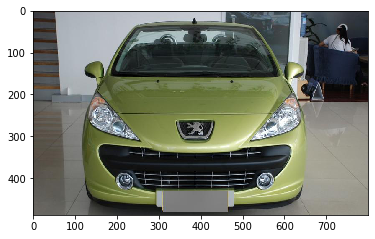

Predicted Make ['Peugeot']	Actual Make ['Peugeot']
Predicted Model ['Peugeot 207CC']	Actual Model ['Peugeot 207CC']


True

In [31]:
##Free to change the 0 to any number specified above!

visualize_perf(4777, classifier, transform, plot=True, print_result=True)